This very simple notebook will take a blood pressure reading log (the provided example data is produced by an OMRON Smart X reader), allocate the readings to three sections of the day (AM, MID and PM) and draw a boxplot to perform a first rough estimate about the presence of a trend. Then plot the measurements in time to give an idea of the trend.

Import needed libraries

In [1]:
# One ring to handle numbers
import pandas as pd
import scipy.stats as stats
# One ring to handle time
import datetime as dt
from datetime import date
import time
# One ring to draw reality
import seaborn as sns
import matplotlib.pyplot as plt
# and One ring to rule them all ;)
# from matplotlib.dates import date2num

Set the (arbitrary) limits to divide the day in an AM, MID(day) and PM areas and the name of data file

In [2]:
AM_LIMIT = 10
PM_LIMIT = 16
LOGNAME = 'data/new_bp_log.csv'
# LOGNAME = '../input/blood-pressure-readings/bp_log.csv' # on Kaggle
# https://www.kaggle.com/rjalexander/blood-pressure-circadian

Define a function to generate a "partofday" categorical label based on the hour of the blood pressure reading and the limits we set above

In [3]:
def partofday(hour):
    if hour <= AM_LIMIT:
        return 'AM'
    elif hour > AM_LIMIT and hour <= PM_LIMIT:
        return 'MID'
    else:
        return 'PM'

Read and take a peek at the data as read in a dataframe

In [4]:
df = pd.read_csv(LOGNAME)

In [5]:
# recreate a Measurement Date text field field like in the old log format to reuse older code
df["Measurement Date"] = df["Date"] + " " + df["Time"]
# also rename the systolic (SYS) and diastolic (DIA) and pulse (Pulse) columns with the old log format names
df.rename(columns = {'Systolic (mmHg)':'SYS', 'Diastolic (mmHg)':'DIA', 'Pulse (bpm)':'Pulse'}, inplace = True)

Add a new "partofday" categorical new column in the dataframe

In [6]:
df['partofday'] = df.apply(lambda row: partofday(pd.to_datetime(row['Measurement Date']).hour), axis=1)

### Add a datetime column and a couple of derived ordinals


In [7]:
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time']) # generate a datetime object from the two Date and Time strings
df['unix'] = df['datetime'].astype('int64')/1e9 # generate seconds from Unix epoch from the datetime object
df['elapsed_seconds'] = (df['datetime']-df['datetime'].min()).dt.total_seconds() # generate seconds from earliest observation time
df.sample(5)

,Date,Time,SYS,DIA,Pulse,Irregular heartbeat detected,Body Movement,Cuff wrap guide,Positioning Indicator,Measurement Mode,Possible Afib,Device,Notes,Measurement Date,partofday,datetime,unix,elapsed_seconds
52,21 Jul 2021,11:57,127,81,66,,,,,,,HEM-7361T_ESL,_,21 Jul 2021 11:57,MID,2021-07-21 11:57:00,1.626869e+09,6483180.0
75,28 Aug 2021,15:53,128,77,71,,,,,,,HEM-7361T_ESL,_,28 Aug 2021 15:53,MID,2021-08-28 15:53:00,1.630166e+09,9780540.0
12,08 May 2021,09:17,125,72,63,,,,,,,HEM-7361T_ESL,_,08 May 2021 09:17,AM,2021-05-08 09:17:00,1.620465e+09,79980.0
23,25 Jun 2021,08:20,112,70,66,,,,,,,HEM-7361T_ESL,_,25 Jun 2021 08:20,AM,2021-06-25 08:20:00,1.624609e+09,4223760.0
47,20 Jul 2021,11:42,129,82,69,,,,,,,HEM-7361T_ESL,_,20 Jul 2021 11:42,MID,2021-07-20 11:42:00,1.626781e+09,6395880.0


Now plot the SYS(tolic) and then the DIA(stolic) pressure values divided in the three sections of the day

In [8]:
sns.set_theme(style="whitegrid")

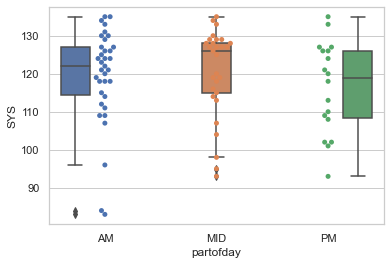

In [9]:
ax = sns.boxplot(x=df["partofday"], y=df["SYS"],hue=df["partofday"],data=df, order=["AM","MID","PM"])
ax = sns.swarmplot(x=df["partofday"], y=df["SYS"],hue=df["partofday"],data=df, order=["AM","MID","PM"])
ax.legend_.remove()

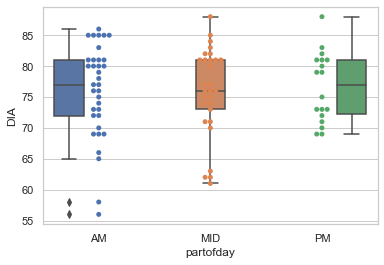

In [10]:
ax = sns.boxplot(x=df["partofday"], y=df["DIA"],hue=df["partofday"],data=df, order=["AM","MID","PM"])
ax = sns.swarmplot(x=df["partofday"], y=df["DIA"],hue=df["partofday"],data=df, order=["AM","MID","PM"])
ax.legend_.remove()

Now let's perform a t-test to see if there's a statistically significant difference in the average BP between AM and PM

In [11]:
stats.ttest_ind(df['SYS'][df['partofday'] == 'AM'], df['SYS'][df['partofday'] == 'PM'])

Ttest_indResult(statistic=0.8454246602947049, pvalue=0.40182280685361227)

In [12]:
stats.ttest_ind(df['DIA'][df['partofday'] == 'AM'], df['DIA'][df['partofday'] == 'PM'])

Ttest_indResult(statistic=-0.27555276498320835, pvalue=0.7840050089402)

Now let's perform a t-test to see if there's a statistically significant difference in the average BP between AM and MIDday

In [13]:
stats.ttest_ind(df['SYS'][df['partofday'] == 'AM'], df['SYS'][df['partofday'] == 'MID'])

Ttest_indResult(statistic=-0.3350853740805134, pvalue=0.7386917916887347)

In [14]:
stats.ttest_ind(df['DIA'][df['partofday'] == 'AM'], df['DIA'][df['partofday'] == 'MID'])

Ttest_indResult(statistic=0.06822278876783652, pvalue=0.9458278331944387)

### Conclusion: no significant distribution variability of blood presure values between the three daily phases 

### Let's now plot the BP values and see what's their temporal trend in time

Now plot a scatterplot with a linear regression fit. To do so as the scattterplot does not accept a datetime timestamp as the x values, I am using the epoch (seconds from 01-jan-1970) contained in the "unix" column

/var/folders/gr/jz04bv8x6sx3t0dx_m_6x72m0000gn/T/ipykernel_68546/3663205825.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


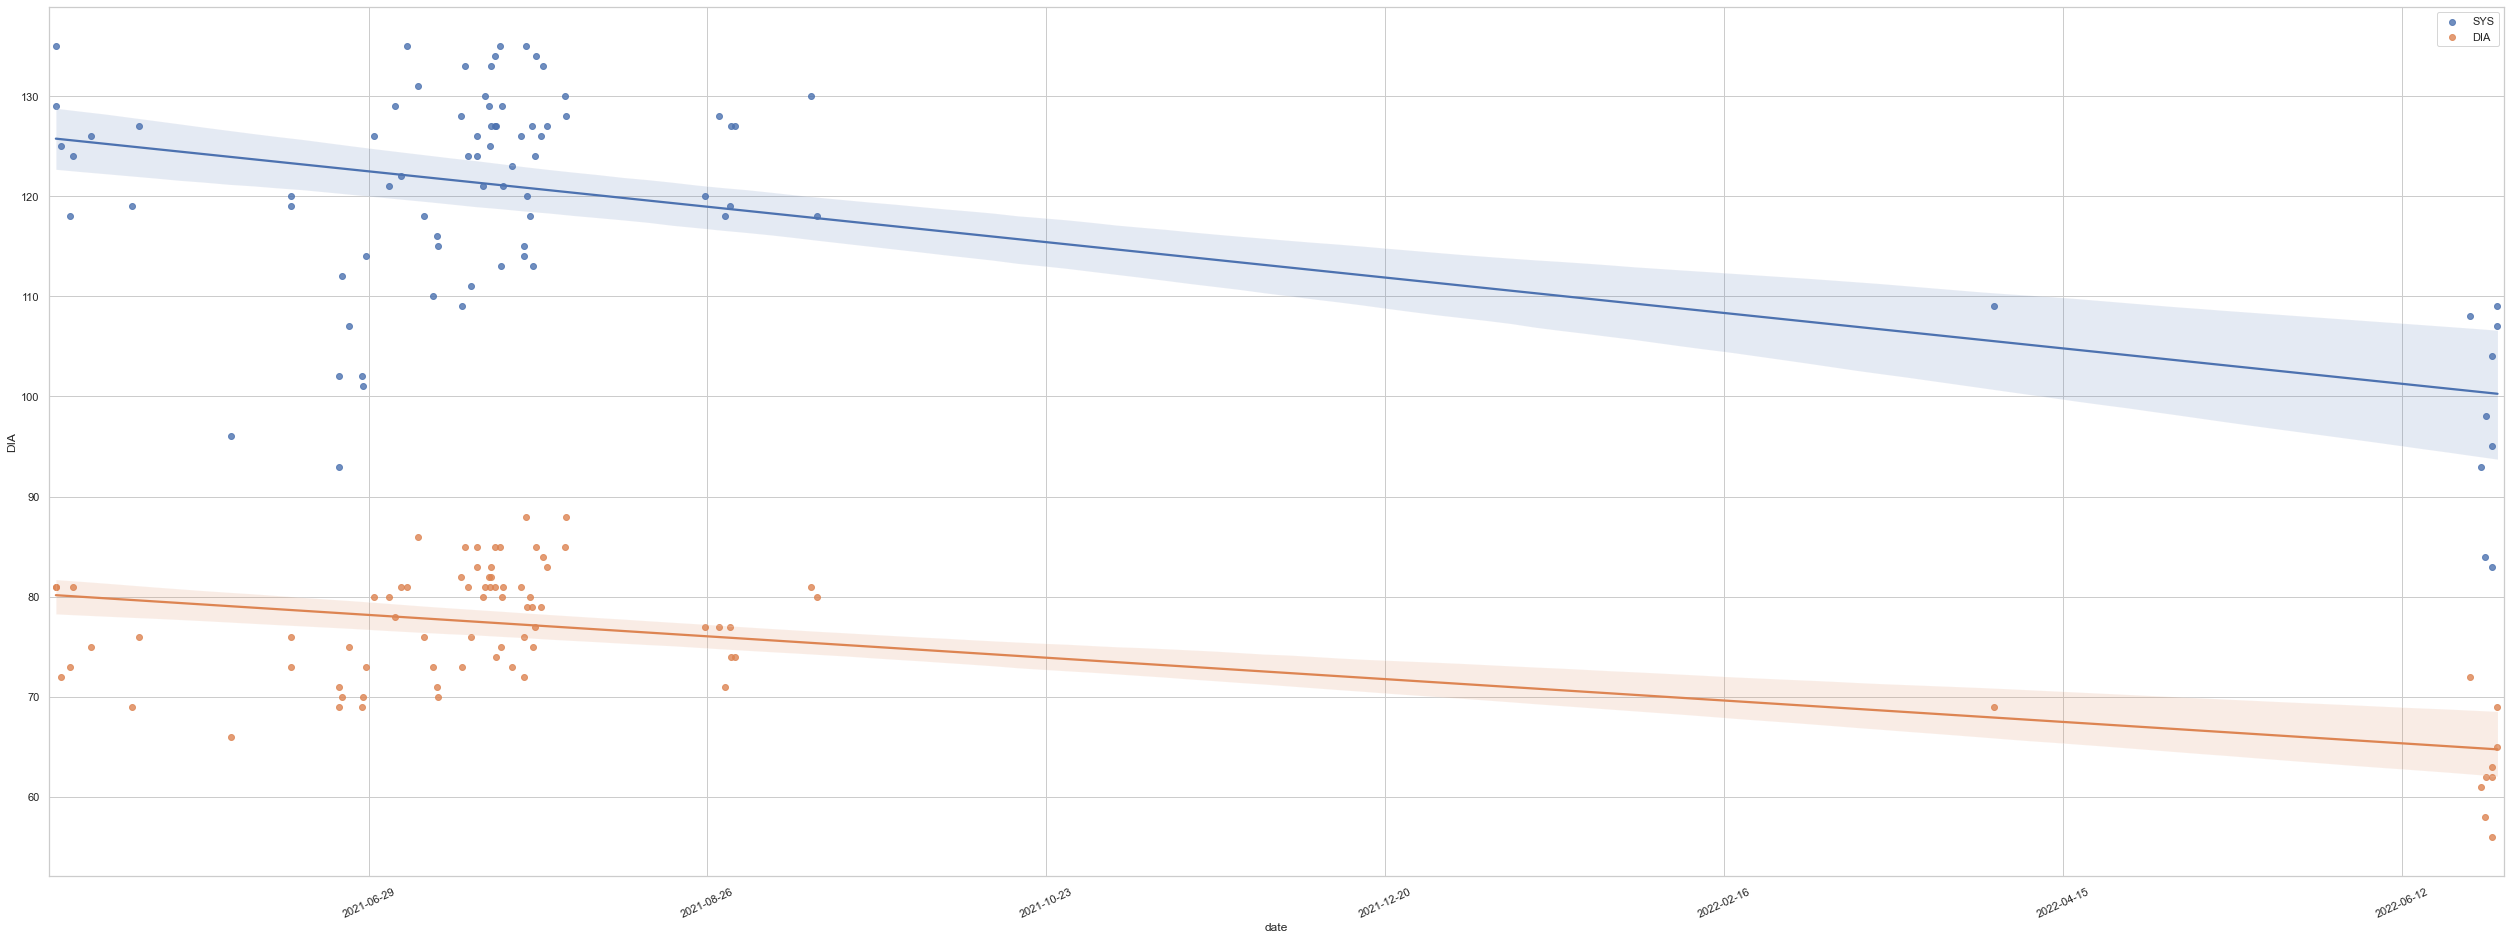

In [15]:
plt.figure(figsize=(44,16))
ax = sns.regplot(x="unix", y="SYS", data=df, label="SYS")
ax = sns.regplot(x="unix", y="DIA", data=df, label="DIA")
# create some whitespace horizontally around the plot values
ax.set_xlim(df['unix'].min() - 100000, df['unix'].max() + 100000)
# now convert the epoch values back to a YYYY-MM-DD string for the x labels
# localtime converts the epoch into a datetime object abd strftime converts it into a string
new_labels = [time.strftime('%Y-%m-%d',time.localtime(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
# set some visuals
ax.set_xlabel('date')
plt.xticks(rotation=25)
plt.legend()
plt.show()

/var/folders/gr/jz04bv8x6sx3t0dx_m_6x72m0000gn/T/ipykernel_68546/3569792281.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='r', linestyle='--')


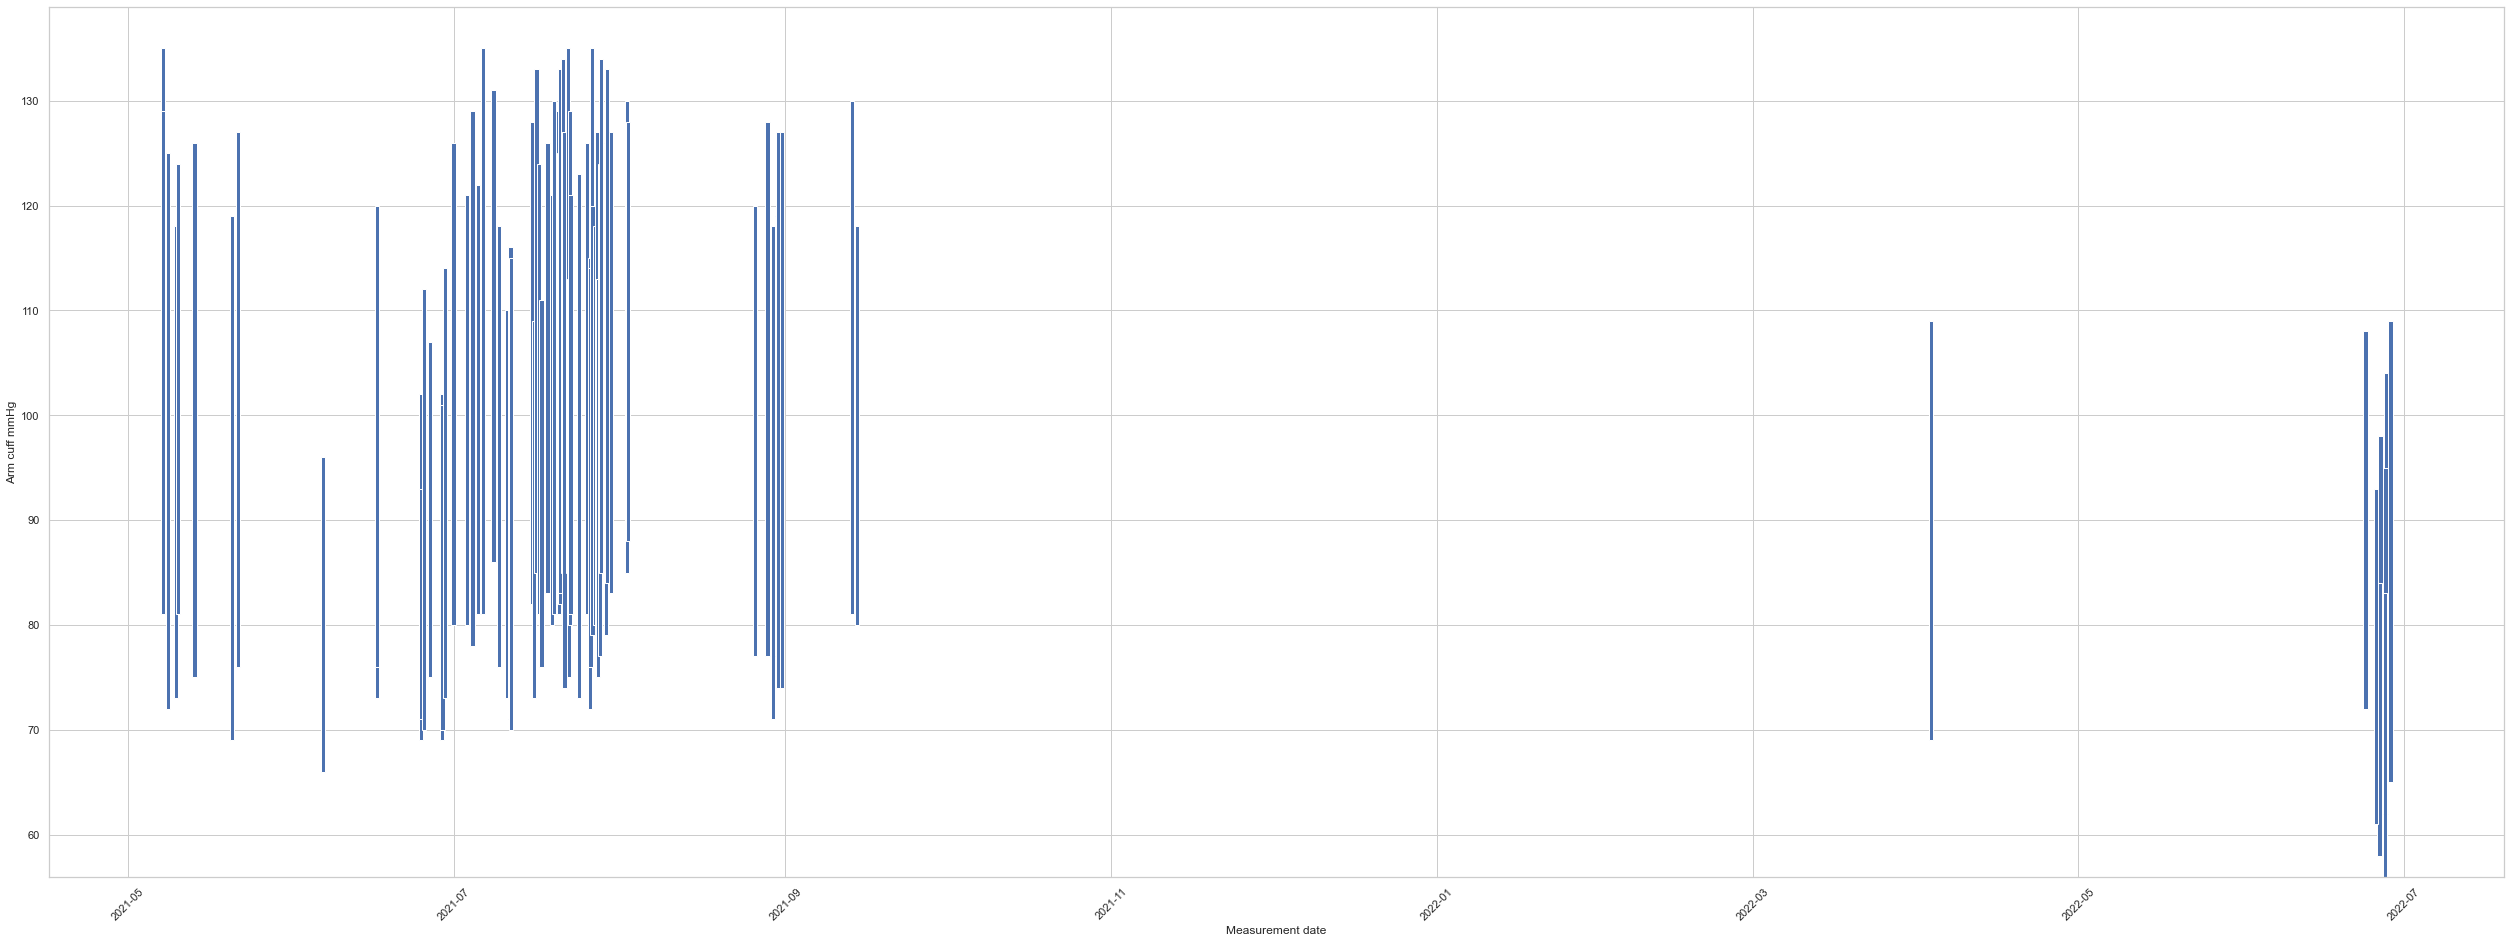

In [19]:
plt.figure(figsize=(44,16))
plt.bar(
    x=df['datetime'],
    height=df['SYS'] - df['DIA'],
    bottom=df['DIA'],
)
plt.grid(b=True, which='minor', color='r', linestyle='--') # does not currently work
plt.xticks(rotation=45)
plt.xlabel("Measurement date")
plt.ylabel("Arm cuff mmHg")
plt.show()